In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import io
from PIL import Image


shape of s: (10000, 2)


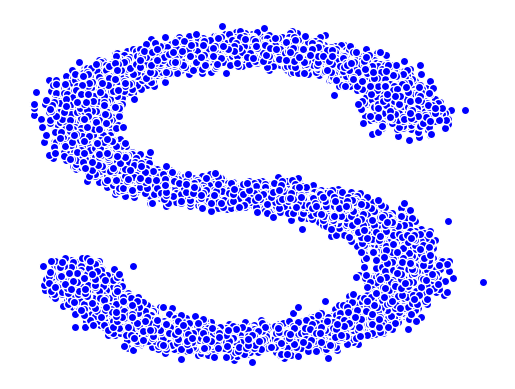

In [10]:
# Select data set
s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='blue',edgecolor='white');

ax.axis('off')
plt.show()
dataset = torch.Tensor(s_curve).float()
# Image "S" contains 10000 points，each point contains two nums.

#### Forward process

In the forward process, the data distribution $q(\mathbf{x}_{0})$ is gradually converted into an analytically tractable distribution $\pi(\mathbf{y})$, by repeated application of a Markov diffusion kernel $T_{\pi}(\mathbf{y}\mid\mathbf{y}';\beta)$, with a given diffusion rate $\beta$. 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = T_{\pi}(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}; \beta_{t})
$$

This diffusion kernel can be set to gradually inject Gaussian noise, given a variance schedule $\beta_{1},\cdots,\beta_{T}$ such that

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

The complete distribution $q(\mathbf{x}_{0:T})$ is called the _diffusion_ process and is defined as

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$

Here, we show how to perform a naive implementation of the simple forward diffusion process with a constant variance schedule

We can define any type of variance schedules for $\beta_{1},\cdots,\beta_{n}$, as provided in the following function

In [7]:
# set values for parameters

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 100

# set methods for beta
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

Interestingly, the forward process admits sampling $\mathbf{x}_{t}$ at an arbitrary timestep $t$. Using notations $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$, we have

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Therefore, we can update our diffusion sampling function to allow for this mecanism. Note that this depends on the given variance schedule of $\beta_{1},\cdots,\beta_{T}$ that we compute prior to the function.

In [8]:
# Calculate alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt

alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [9]:
# Forward process

# According to the provement, we can directly sample at any given timesteps (add noise)
# x[0] -> x[t]
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)


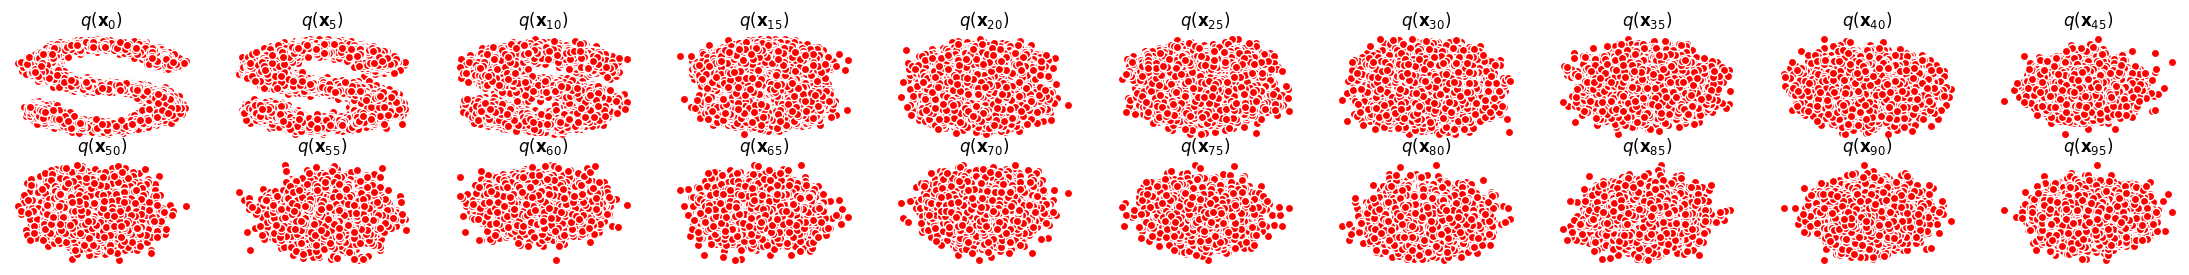

In [10]:
# show the results of forward process (when origin image add noise)
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

# total 100 steps, every 5 steps output 1 plot.
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) # x[t] 
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

#### Reverse process

The generative distribution that we aim to learn will be trained to perform the _reverse_ trajectory, starting from Gaussian noise to gradually remove local perturbations. Therefore the reverse process starts with our given tractable distribution $p(\mathbf{x}_{T})=\pi(\mathbf{x}_{T})$ and is described as

$$
p_{\theta}(\mathbf{x}_{0:T}) =  p(\mathbf{x}_{T}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

Each of the transitions in this process can simply be defined as conditional Gaussians (**note**: which is reminiscent of the definition of VAEs). Therefore, during learning, only the mean and covariancce for a Gaussian diffusion kernel needs to be trained

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

The two functions defining the mean $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ can be parametrized by deep neural networks. Note also that these functions are parametrized by $t$, which means that a single model can be used for all time steps.

Here, we show a naive implementation of this process, where we have a given `model` to infer variance. Note that this model is _shared across all time steps_ but conditionned on that said time step.

In [12]:
# Reverse process

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        #         x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x

Finally, obtaining samples from the model is given by running through the whole Markov chain in reverse, starting from the normal distribution to obtain samples from the target distribution. Note that this process can be very slow if we have a large number of steps, as we need to wait for a given $\mathbf{x}_{t}$ to infer the following $\mathbf{x}_{t-1}$

In [13]:
# Inference
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """from x[T] sampling"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x, t)

    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """from x[T] to x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

### Training

By using Jensen's inequality on the previous expression, we can see that the training may be performed by optimizing the variational bound on negative log-likelihood

\begin{align}
\mathbb{E}\left[-\log p_{\theta}(\mathbf{x}_{0}) \right] & \leq \mathbb{E}_{q}\left[-\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_{0})} \right] \\
\mathcal{L} & = \mathbb{E}_{q}\left[ -\log p(\mathbf{x}_{T}) - \sum_{t\geq 1} \log \frac{p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})}{q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})} \right]
\end{align}

Therefore, efficient training is allowed by optimizing random terms of $\mathcal{L}$ with gradient descent.

To optimize this loss, we will need several computational tools, notably the KL divergence between two gaussians, and the entropy of a Gaussian.

### Training loss

In the original paper by Sohl-Dickstein et al. [ [ 1 ] ](#ref1), this loss is shown to be reducible to

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align}

Hence, all parts of this loss can be quite easily estimated, as we are dealing with Gaussian distributions in all cases

In [12]:
# loss function
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)
    t = t.unsqueeze(-1)

    # x0的系数
    a = alphas_bar_sqrt[t]

    # eps的系数
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

In [ ]:
# Training model
seed = 1234

class EMA():
    """构建一个参数平滑器"""

    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average


print('Training model...')


batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()


    # print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) # 共100个元素

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white');
            axs[i - 1].set_axis_off();
            axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')

These plots show some samples of training. With the increasing of num_epoch, final results of the reserve sequence is more close to the true data distribution.
![output](output1.png)
![output](output2.png)
![output](output3.png)
![output](output4.png)

In [ ]:
# Generating the forward image sequence.
imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off');

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

In [ ]:
# Generating the reserve diffusion sequense
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

imgs = imgs +reverse

imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)

This gif shows the progress of how the picture into noise, and then reserve.  
![output](diffusion.gif)